# COVID19 - April 2020 Forecast
### A simple LSTM to predict time series

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import datetime

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/covid19-global-forecasting-week-2/train.csv
/kaggle/input/covid19-global-forecasting-week-2/submission.csv
/kaggle/input/covid19-global-forecasting-week-2/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-2/train.csv')

## Exploration

In [3]:
display(train_df.head())
display(train_df.info())

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19698 entries, 0 to 19697
Data columns (total 6 columns):
Id                19698 non-null int64
Province_State    8375 non-null object
Country_Region    19698 non-null object
Date              19698 non-null object
ConfirmedCases    19698 non-null float64
Fatalities        19698 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 923.5+ KB


None

In [4]:
print('We have', len(train_df.Country_Region.unique()), 'countries/regions in the dataset.')
print('We have', len(train_df.Province_State.unique()), 'provinces/states in the dataset.')

We have 173 countries/regions in the dataset.
We have 126 provinces/states in the dataset.


In [5]:
num_fatalities = train_df.loc[train_df['Date'] == train_df['Date'].max()]['Fatalities'].sum()
print('Between {} and {} there are {} fatalities.'.format(train_df['Date'].min(), train_df['Date'].max(), int(num_fatalities)))

Between 2020-01-22 and 2020-03-28 there are 30646 fatalities.


In [6]:
cz_sick = int(train_df.loc[(train_df['Country_Region'] == 'Czechia') & (train_df['Date'] == train_df['Date'].max())]['ConfirmedCases'].values[0])
cz_fatalities = int(train_df.loc[(train_df['Country_Region'] == 'Czechia') & (train_df['Date'] == train_df['Date'].max())]['Fatalities'].values[0])
print('In Czech Republic there are {} confirmed cases and {} fatalities.'.format(cz_sick, cz_fatalities))

In Czech Republic there are 2631 confirmed cases and 11 fatalities.


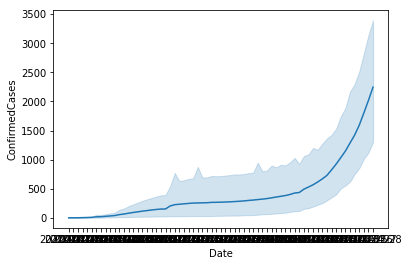

In [7]:
timetrend_sick = sns.lineplot(train_df['Date'], train_df['ConfirmedCases'])

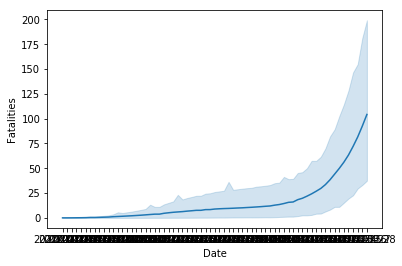

In [8]:
timetrend_deceased = sns.lineplot(train_df['Date'], train_df['Fatalities'])

## Transformation, Pre-processing

In [9]:
# Add a new column to be able to distinguish regions

train_df['UniqueRegion'] = np.where(train_df['Province_State'].isna(), train_df['Country_Region'], train_df['Country_Region'] + ' - ' + train_df['Province_State'])

In [10]:
# Calculate number of new sick per day

countries = train_df['UniqueRegion'].unique()
train_df['SickPerDay'] = 0

baseline_length = len(train_df.loc[train_df['UniqueRegion'] == 'Afghanistan']) # Country chosen arbitrarily

for country in countries:
    len_country = len(train_df.loc[train_df['UniqueRegion'] == country])
    len_diffs = len(train_df.loc[train_df['UniqueRegion'] == country]['ConfirmedCases'].diff())
    if len_country > baseline_length or len_diffs > baseline_length:
        raise NameError('Too many rows for country {}'.format(country))
    train_df['SickPerDay'].loc[(train_df['UniqueRegion'] == country)] = train_df.loc[train_df['UniqueRegion'] == country]['ConfirmedCases'].diff()
    
train_df['SickPerDay'] = train_df['SickPerDay'].fillna(0)

# Show an example
display(train_df.loc[train_df['UniqueRegion'] == 'Czechia'].tail())

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,UniqueRegion,SickPerDay
6092,9063,NaN,Czechia,2020-03-24,1394.0,3.0,Czechia,158.0
6093,9064,NaN,Czechia,2020-03-25,1654.0,6.0,Czechia,260.0
6094,9065,NaN,Czechia,2020-03-26,1925.0,9.0,Czechia,271.0
6095,9066,NaN,Czechia,2020-03-27,2279.0,9.0,Czechia,354.0
6096,9067,NaN,Czechia,2020-03-28,2631.0,11.0,Czechia,352.0


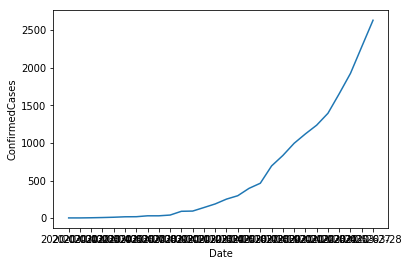

In [11]:
sns.lineplot(train_df.loc[(train_df['UniqueRegion'] == 'Czechia') & (train_df['ConfirmedCases'] > 0)]['Date'], train_df.loc[(train_df['UniqueRegion'] == 'Czechia')& (train_df['ConfirmedCases'] > 0)]['ConfirmedCases'])

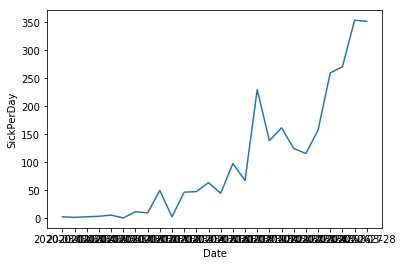

In [12]:
sns.lineplot(x=train_df.loc[(train_df['UniqueRegion'] == 'Czechia') & (train_df['SickPerDay'] > 0)]['Date'],
             y=train_df.loc[(train_df['UniqueRegion'] == 'Czechia')& (train_df['SickPerDay'] > 0)]['SickPerDay'])

In [13]:
top10_most_cases = train_df.loc[train_df['Date'] == train_df['Date'].max()][['UniqueRegion','ConfirmedCases']].sort_values(by='ConfirmedCases', ascending=False).head(10)
top10_most_deceased = train_df.loc[train_df['Date'] == train_df['Date'].max()][['UniqueRegion','Fatalities']].sort_values(by='Fatalities', ascending=False).head(10)
top10_most_sick_per_day = train_df.loc[train_df['Date'] == train_df['Date'].max()][['UniqueRegion','SickPerDay']].sort_values(by='SickPerDay', ascending=False).head(10)

In [14]:
top10_most_cases_df = train_df.loc[train_df['UniqueRegion'].isin(top10_most_cases['UniqueRegion'].values)]

In [15]:
# Transform the dataframe to show each country in a different column

main_df = pd.DataFrame()

for i, top10_country in enumerate (top10_most_cases_df['UniqueRegion'].unique()):
    if i == 0:
        main_df = top10_most_cases_df.loc[top10_most_cases_df['UniqueRegion'] == top10_country][['Date', 'ConfirmedCases']].sort_values(by='Date')
        main_df = main_df.rename({'ConfirmedCases': top10_country}, axis='columns')

    else:
        temp_df = top10_most_cases_df.loc[top10_most_cases_df['UniqueRegion'] == top10_country][['Date', 'ConfirmedCases']]
        temp_df = temp_df.rename({'ConfirmedCases': top10_country}, axis='columns')
        main_df = pd.merge(main_df, temp_df, on=['Date'])

main_df = main_df.set_index('Date')
main_df.head()

,China - Hubei,France,Germany,Iran,Italy,Spain,Switzerland,US - New Jersey,US - New York,United Kingdom
Date,,,,,,,,,,
2020-01-22,444.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,444.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,549.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,761.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,1058.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


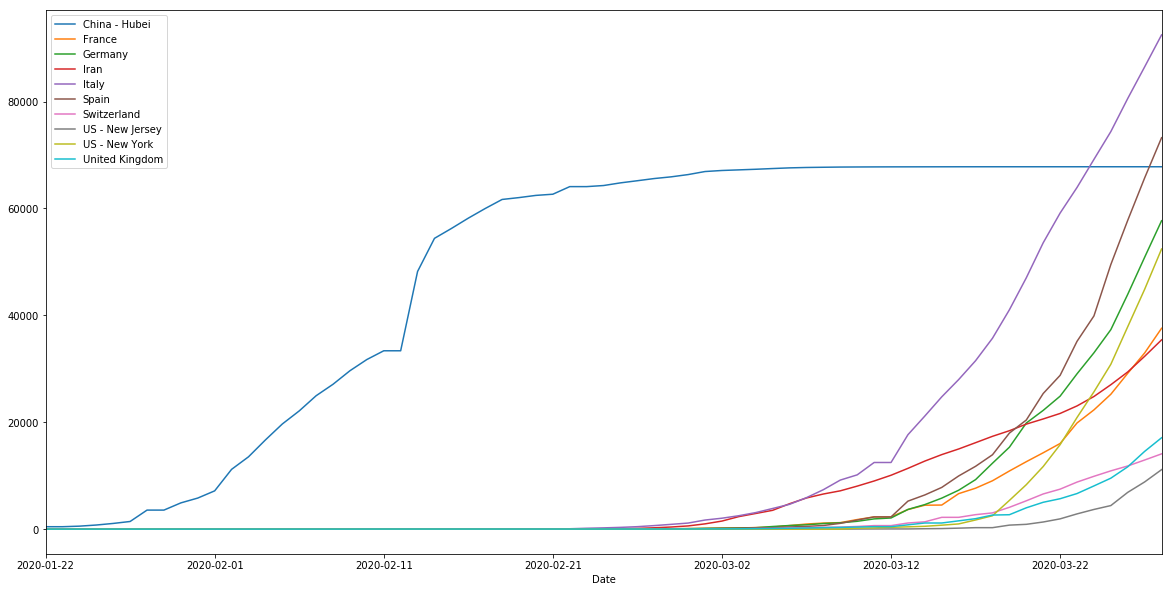

In [16]:
main_df.plot(figsize=(20,10))

In [17]:
# Transform main data into a horizontal dataframe

def transform_horizontally(input_df, value_column):

    horizontal_df = pd.DataFrame()

    for i, uniqueRegion in enumerate (input_df['UniqueRegion'].unique()):
        if i == 0:
            horizontal_df = input_df.loc[input_df['UniqueRegion'] == uniqueRegion][['Date', value_column]].sort_values(by='Date')
            horizontal_df = horizontal_df.rename({value_column: uniqueRegion}, axis='columns')

        else:
            temp_df = input_df.loc[train_df['UniqueRegion'] == uniqueRegion][['Date', value_column]]
            temp_df = temp_df.rename({value_column: uniqueRegion}, axis='columns')
            horizontal_df = pd.merge(horizontal_df, temp_df, on=['Date'])
            
    return horizontal_df

In [18]:
confirmed_horizontal_df = transform_horizontally(train_df, 'ConfirmedCases').sort_values(by='Date')
fatalities_horizontal_df = transform_horizontally(train_df, 'Fatalities').sort_values(by='Date')


display(confirmed_horizontal_df.head())
display(confirmed_horizontal_df.shape)

display(fatalities_horizontal_df.head())
display(fatalities_horizontal_df.shape)

,Date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia - Australian Capital Territory,...,United Kingdom - Gibraltar,United Kingdom - Isle of Man,United Kingdom - Montserrat,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
0,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


(67, 295)

,Date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia - Australian Capital Territory,...,United Kingdom - Gibraltar,United Kingdom - Isle of Man,United Kingdom - Montserrat,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
0,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(67, 295)

In [19]:
# Convert dataframes into numpy arrays

np_confirmed = confirmed_horizontal_df.drop(columns=['Date']).to_numpy()
np_confirmed

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   2.,   0.,   0.],
       [  0.,   0.,   0., ...,   2.,   0.,   0.],
       ...,
       [ 94., 174., 367., ..., 153.,  16.,   3.],
       [110., 186., 409., ..., 163.,  22.,   5.],
       [110., 197., 454., ..., 174.,  28.,   7.]])

In [20]:
# Scale the values (better performance of LSTM)
scaler = MinMaxScaler(feature_range = (0, 1))
np_confirmed_scaled = scaler.fit_transform(np_confirmed)

In [21]:
# Split a multivariate sequence into samples
# Credits to: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [22]:
n_steps_in = 11
n_steps_out = 1

X, y = split_sequences(np_confirmed_scaled, n_steps_in, n_steps_out)

In [23]:
n_features = X.shape[2]
display(n_features)

294

In [ ]:
# Define model
model = Sequential()
model.add(LSTM(1000, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(5000, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(5000, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(5000, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(1000, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

model.summary()

In [25]:
model.fit(X, y, epochs=300, verbose=0)

In [26]:
X_pred = np_confirmed_scaled[-n_steps_in-1:-n_steps_out].reshape((1, n_steps_in, n_features))
y_pred = model.predict(X_pred)

In [27]:
print(list(np_confirmed[-1]))
rounded_pred = [int(x) for x in scaler.inverse_transform(y_pred[0])[0].astype(int)]
print(rounded_pred)

[110.0, 197.0, 454.0, 308.0, 5.0, 7.0, 690.0, 407.0, 71.0, 1617.0, 15.0, 625.0, 287.0, 62.0, 685.0, 278.0, 8271.0, 182.0, 10.0, 476.0, 48.0, 26.0, 94.0, 9134.0, 2.0, 6.0, 3.0, 74.0, 258.0, 3904.0, 120.0, 331.0, 207.0, 5.0, 99.0, 91.0, 542.0, 884.0, 64.0, 51.0, 120.0, 110.0, 1144.0, 11.0, 2498.0, 134.0, 3.0, 3.0, 1909.0, 990.0, 573.0, 578.0, 337.0, 136.0, 1467.0, 254.0, 146.0, 168.0, 319.0, 484.0, 1275.0, 561.0, 67801.0, 1018.0, 94.0, 641.0, 936.0, 97.0, 132.0, 37.0, 75.0, 18.0, 253.0, 772.0, 485.0, 135.0, 548.0, 161.0, 1.0, 76.0, 180.0, 1251.0, 608.0, 4.0, 65.0, 295.0, 101.0, 657.0, 119.0, 179.0, 2631.0, 155.0, 10.0, 2201.0, 712.0, 14.0, 11.0, 719.0, 1823.0, 576.0, 19.0, 12.0, 6.0, 645.0, 9.0, 16.0, 5.0, 1167.0, 28.0, 30.0, 102.0, 93.0, 63.0, 15.0, 183.0, 5.0, 11.0, 37575.0, 7.0, 3.0, 90.0, 57695.0, 141.0, 1061.0, 7.0, 34.0, 8.0, 2.0, 8.0, 8.0, 6.0, 95.0, 343.0, 963.0, 987.0, 1155.0, 35408.0, 506.0, 2415.0, 3619.0, 92472.0, 30.0, 1693.0, 246.0, 228.0, 38.0, 9478.0, 235.0, 58.0, 8.0, 30

In [29]:
# Read test set

test_df = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-2/test.csv')

In [99]:
# Predict for the necessary number of days

num_days_to_predict = datetime.datetime.strptime(test_df['Date'].max(), '%Y-%m-%d') - datetime.datetime.strptime(train_df['Date'].max(), '%Y-%m-%d')
num_days_to_predict.days

# Copy the train set for the purposes of prediction
X_test = np_confirmed_scaled.copy()

for day in range(num_days_to_predict.days):
#for day in range(1):
    X_pred_temp = X_test[-n_steps_in:].reshape((1, n_steps_in, n_features))
    y_pred_temp = model.predict(X_pred_temp)
    #display(y_pred_temp.shape)
    X_test = np.append(X_test, y_pred_temp[0], axis=0)
    
    # Add the prediction to X_test
    
print('We have', X_test.shape[0], 'days after predicting.')

We have 100 days after predicting.


In [84]:
X_test.shape

(100, 294)

In [97]:
rounded_pred = [int(x) for x in scaler.inverse_transform(X_test)[-1]]
print(rounded_pred[90])

1540842


In [100]:
list(train_df['UniqueRegion'].unique()).index('Czechia')
train_df['UniqueRegion'].unique()[90]

'Czechia'